In [1]:
#in this notebook, I also attempt to find how each STU filter can be represented as a linear combination of LDSs
#however, to do this we will fit many STUs to LDSs and then use the learned weights to represent the STU as a linear combination of LDSs

In [17]:
import sys
import os
sys.path.append(os.path.abspath("../../src"))

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional  as  F
import math
import numpy as np

device = torch.device("cuda"  if torch.cuda.is_available() else "cpu")

In [19]:
def nearest_power_of_two(x: int, round_up: bool = False) -> int:
    return (
        1 << math.floor(math.log2(x)) if not round_up else 1 << math.ceil(math.log2(x))
    )

def convolve(u: torch.Tensor, v: torch.Tensor, n: int, use_approx: bool = True) -> tuple[torch.Tensor, torch.Tensor]:
    # print(u.shape, v.shape)
    bsz, seq_len, d_in = u.shape

    sgn = torch.full((1, seq_len, 1), 1, device=u.device)
    sgn[:, 1::2] *= -1

    _, K = v.shape
    sgn = sgn.unsqueeze(-1)
    v = v.view(1, -1, K, 1, 1).to(torch.float32) # (bsz, seq_len, K, d_in, stack)
    u = u.view(bsz, -1, 1, d_in).expand(bsz, -1, K, d_in)

    v = torch.fft.rfft(v, n=n, dim=1)
    U = torch.stack([u, u * sgn], dim=-1).to(torch.float32)
    U = torch.fft.rfft(U, n=n, dim=1)
    U_conv = torch.fft.irfft(v * U, n=n, dim=1)[:, :seq_len]
    U_plus, U_minus = torch.unbind(U_conv, dim=-1)
    U_minus = U_minus * sgn

    return U_plus, U_minus

In [20]:
def get_hankel(seq_len: int, use_hankel_L: bool = False) -> np.ndarray:
    entries = np.arange(1, seq_len + 1, dtype=np.float64)
    i_plus_j = entries[:, None] + entries[None, :]

    if use_hankel_L:
        sgn = (-1.0) ** (i_plus_j - 2.0) + 1.0
        denom = (i_plus_j + 3.0) * (i_plus_j - 1.0) * (i_plus_j + 1.0)
        Z = sgn * (8.0 / denom)
    elif not use_hankel_L:
        Z = 2.0 / (i_plus_j**3 - i_plus_j)
    else:
        raise ValueError("use_hankel_L must be a boolean")

    return Z

def get_spectral_filters(
    seq_len: int,
    K: int,
    use_hankel_L: bool = False,
    device: torch.device = None,
    dtype: torch.dtype = torch.bfloat16,
) -> torch.Tensor:
    # assert torch.cuda.is_available(), "CUDA is required."
    Z = get_hankel(seq_len, use_hankel_L)
    sigma, phi = np.linalg.eigh(Z)
    sigma_k, phi_k = sigma[-K:], phi[:, -K:]
    phi_k *= sigma_k ** 0.25
    filters = torch.from_numpy(phi_k)
    return filters.to(device=device, dtype=dtype)


In [21]:
from lds_utils import compute_ar_x_preds

In [346]:
class STU(nn.Module):
    def __init__(self, config, phi) -> None:
        super(STU, self).__init__()
        self.config = config
        self.phi = phi
        self.n = nearest_power_of_two(config['seq_len'] * 2 - 1, round_up=True)
        self.K = config['num_eigh']
        self.d_in = config['d_in']
        self.d_out = config['d_out']
        self.use_hankel_L = config['use_hankel_L']
        self.use_approx = False
        self.k_u = config['k_u']

        self.M = nn.Parameter(torch.randn(self.d_out, self.d_in, self.k_u, dtype=config['torch_dtype']) / self.d_in)
        
        self.M_phi_plus = nn.Parameter(
            torch.randn(self.K, self.d_in, self.d_out, dtype=config['torch_dtype']) / 10
        )

        self.M_phi_minus = nn.Parameter(
            torch.randn(self.K, self.d_in, self.d_out, dtype=config['torch_dtype']) / 10
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        # Convolve inputs and filters,
        U_plus, U_minus = convolve(x, self.phi, self.n, False)
        # Then, contract over the K and d_in dimensions

        # print(U_plus.shape, U_minus.shape)
        spectral_plus = torch.tensordot(
            U_plus, self.M_phi_plus, dims=([2, 3], [0, 1])
        )

        spectral_minus = torch.tensordot(
            U_minus, self.M_phi_minus, dims=([2, 3], [0, 1])
        )
            
        output = spectral_plus if self.use_hankel_L else spectral_plus + spectral_minus
        ar = compute_ar_x_preds(self.M, x)
        return output + ar
        
    def loss(self, inputs, targets):
        pred = self.forward(inputs)
        # print(pred, targets)
        loss = F.mse_loss(pred, targets)
        return  loss



In [347]:
class LDS:
  def __init__(self, A: torch.tensor, B: torch.tensor, C: torch.tensor, D: torch.tensor, h0: torch.tensor):
    self.d_h = A.shape
    _, self.d_u = B.shape
    self.d_o, _ = C.shape
    self.A = A  # hidden state dynamics
    self.B = B  # hidden state dynamics
    self.C = C  # observation projection
    self.D = D  # observation projection
    self.h0 = h0  # initial hidden state
    self.h = h0  # current hidden state
    self.dtype = float

  def step(self, u: torch.tensor) -> torch.tensor:
    assert u.shape == (self.d_u,)
    h_next = self.A * self.h + self.B @ u
    obs = self.C @ h_next + self.D @ u
    self.h = h_next
    assert obs.shape == (self.d_o,)
    return obs

  def reset(self):
    self.h = self.h0
    return self

  def generate_trajectory(self, us: torch.tensor, h0: torch.tensor = None) -> torch.tensor:
    if h0 is not None:
      self.h = h0
    _, d_u = us.shape
    assert d_u == self.d_u, (d_u, self.d_u)
    obs = []
    for u in us:
      obs.append(self.step(u))
    return torch.stack(obs, dim=0)

def random_LDS(d_h: int, d_o: int, d_u: int, lower_bound: float):
  """
  makes a random LDS with hidden state dimension d_h, observation dimension d_o, and control dimension d_u.
  `lower_bound` is a float in [0, 1] specifying the minimum absolute value for entries in A.
  Each entry in A will be in [lower_bound, 1] multiplied by +/-1 with equal probability.
  """
  # Generate random values in [lower_bound, 1]
  A = torch.rand(d_h) * (1 - lower_bound) + lower_bound
  signs = torch.randint(0, 2, (d_h,)) * 2 - 1
  A = A * signs.float()
  
  B = torch.randn(d_h, d_u).to(device)
  C = torch.randn(d_o, d_h).to(device)
  D = torch.zeros(d_o, d_u).to(device)
  h0 = torch.zeros(d_h).to(device)
  return LDS(A.to(device), B, C, D, h0)

In [348]:
d_h = 1
d_in = 1
d_out =1
lds  =  random_LDS(d_h = d_h, d_o =  d_out, d_u = d_in, lower_bound= 0.9)
print(lds.A)

tensor([0.9144], device='cuda:0')


In [349]:
seq_len = 1024
num_eigh = 20
use_hankel_L  = True
phi= get_spectral_filters(seq_len = seq_len, K = num_eigh,  use_hankel_L= use_hankel_L,
                                device  = device,  dtype = torch.float32)

stu_config = {
    "num_eigh": num_eigh,
    "use_hankel_L": True,
    "torch_dtype": torch.float32,
    "d_in": 1,
    "d_out": 1,
    "seq_len": seq_len,
    "k_u": 3
}


In [350]:
def train_stu(lds, verbose = True):
    model = STU(stu_config, phi).to(device)
    lr = 1
    optimizer = torch.optim.Adagrad(model.parameters(), lr=lr)

    steps = 500 # @param
    model.train()

    bsz = 1

    for step in range(steps):
        inputs = torch.randn(bsz * seq_len, d_in).to(device)
        targets = lds.reset().generate_trajectory(inputs)

        inputs = inputs.reshape(bsz, seq_len, d_in).to(device)
        targets = targets.reshape(bsz, seq_len, d_out).to(device)
        loss = model.loss(inputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step % 100 == 0 and verbose:
            print(f"Step {step}: Loss = {loss.item()}")

    model.eval()
    return model, loss

stu_model, _ = train_stu(lds)

Step 0: Loss = 12.131586074829102
Step 100: Loss = 5.3135285270400345e-05
Step 200: Loss = 4.853899736190215e-05
Step 300: Loss = 5.1611626986414194e-05
Step 400: Loss = 5.2955732826376334e-05


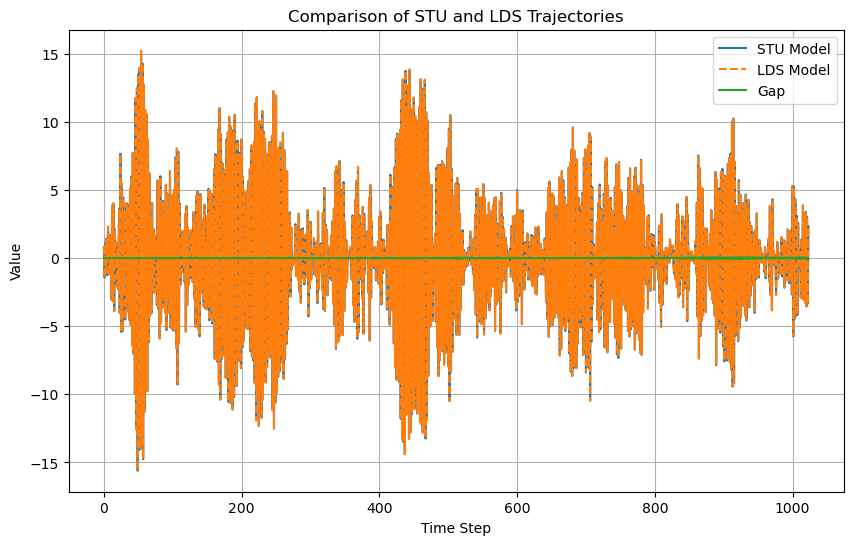

In [80]:
import matplotlib.pyplot as plt

# Generate random input and get trajectories
test_input = torch.randn(seq_len, d_in).to(device)
test_input = test_input.unsqueeze(0) # Add batch dimension

# Get STU trajectory
with torch.no_grad():
    stu_trajectory = stu_model(test_input).squeeze()

# Get LDS trajectory 
lds_trajectory = lds.reset().generate_trajectory(test_input.squeeze(0)).to(device)

gap = stu_trajectory - lds_trajectory[:, 0]
# Plot both trajectories
plt.figure(figsize=(10, 6))
plt.plot(stu_trajectory.cpu().numpy(), label='STU Model')
plt.plot(lds_trajectory.cpu().numpy(), label='LDS Model', linestyle='--')
plt.plot(gap.cpu().numpy(), label='Gap')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Comparison of STU and LDS Trajectories')
plt.legend()
plt.grid(True)
plt.show()


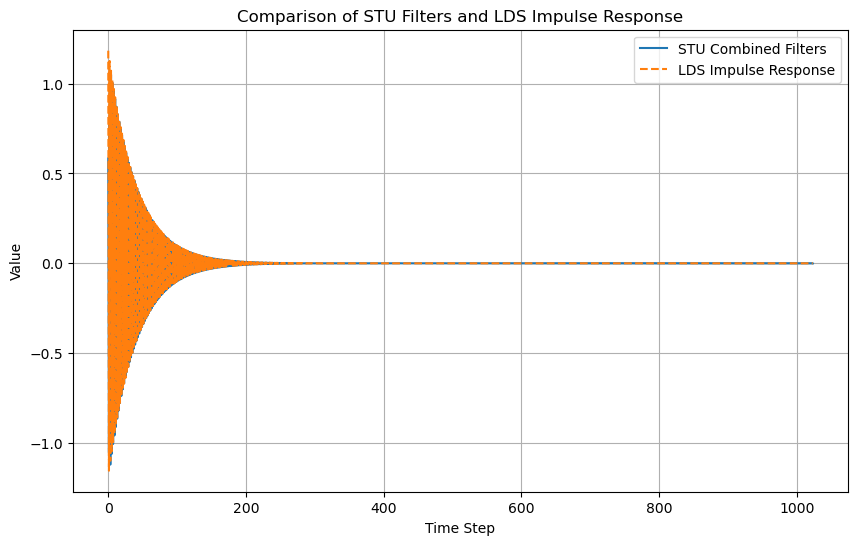

In [301]:
# Get the STU filters and weights
filters = phi.T  # Shape: [num_filters, seq_len]
pos_weights = stu_model.M_phi_plus[:,0,0] # Shape: [1, num_filters]
neg_weights = stu_model.M_phi_minus[:,0,0] # Shape: [1, num_filters]
# Multiply each filter by its weight and sum
pos_weighted_filters = (filters.T @ pos_weights.T).squeeze()  # Shape: [seq_len]
neg_weighted_filters = (filters.T @ neg_weights.T).squeeze()  # Shape: [seq_len]

weighted_filters = pos_weighted_filters + neg_weighted_filters

# For LDS, compute the impulse response
lds_impulse = torch.zeros(seq_len)
for i in range(seq_len):
    a_power = lds.A ** i
    lds_impulse[i] = torch.sum(lds.C[:,0] * a_power * lds.B[0])

# Plot both
plt.figure(figsize=(10, 6))
plt.plot(weighted_filters.detach().cpu().numpy(), label='STU Combined Filters')
plt.plot(lds_impulse.cpu().numpy(), label='LDS Impulse Response', linestyle='--')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Comparison of STU Filters and LDS Impulse Response')
plt.legend()
plt.grid(True)
plt.show()


In [373]:
import numpy as np
import tqdm

ldss = []
pos_weights_matrix = []
neg_weights_matrix = []
autoreg_weights_matrix = []
losses = []
store = []

In [ ]:
for i in tqdm.tqdm(range(200)):
 
    new_lds = random_LDS(d_h = d_h, d_o = d_out, d_u = d_in, lower_bound= 0.95)  # Replace LDS with the actual class constructor if different
    
    # Fit STU to the LDS
    stu, loss = train_stu(new_lds, verbose = False)
    
    # Extract positive and negative weights
    pos_weights = stu.M_phi_plus[:, 0, 0].detach().cpu().numpy()  # Shape: [num_filters]
    neg_weights = stu.M_phi_minus[:, 0, 0].detach().cpu().numpy()  # Shape: [num_filters]
    auto_reg = stu.M.detach().cpu().numpy()
    autoreg_weights_matrix.append(auto_reg)
    
    pos_weights_matrix.append(pos_weights)
    neg_weights_matrix.append(neg_weights)
    losses.append(loss)
    store.append([new_lds, stu])

    ldss.append(new_lds)


  0%|          | 0/200 [00:00<?, ?it/s]

In [116]:
losses

[tensor(2.0206e-05, device='cuda:0', grad_fn=<MseLossBackward0>),
 tensor(5.3262e-05, device='cuda:0', grad_fn=<MseLossBackward0>),
 tensor(3.2637e-05, device='cuda:0', grad_fn=<MseLossBackward0>),
 tensor(1.6736e-05, device='cuda:0', grad_fn=<MseLossBackward0>),
 tensor(1.9032e-06, device='cuda:0', grad_fn=<MseLossBackward0>),
 tensor(5.7230e-07, device='cuda:0', grad_fn=<MseLossBackward0>),
 tensor(3.6279e-05, device='cuda:0', grad_fn=<MseLossBackward0>),
 tensor(0.0542, device='cuda:0', grad_fn=<MseLossBackward0>),
 tensor(1.9968e-05, device='cuda:0', grad_fn=<MseLossBackward0>),
 tensor(6.1585e-06, device='cuda:0', grad_fn=<MseLossBackward0>),
 tensor(1.3804e-05, device='cuda:0', grad_fn=<MseLossBackward0>),
 tensor(8.2415e-06, device='cuda:0', grad_fn=<MseLossBackward0>),
 tensor(14.1267, device='cuda:0', grad_fn=<MseLossBackward0>),
 tensor(3.9855e-05, device='cuda:0', grad_fn=<MseLossBackward0>),
 tensor(1.7003e-05, device='cuda:0', grad_fn=<MseLossBackward0>),
 tensor(1.4137e-0

In [299]:
# Convert losses to numpy array for easier manipulation
losses_np = np.array([loss.item() for loss in losses])

# Get indices of n lowest losses
best_indices = np.argsort(losses_np)[:20]



In [300]:
best_pos_weights = np.stack([pos_weights_matrix[i] for i in best_indices])
best_neg_weights = np.stack([neg_weights_matrix[i] for i in best_indices])
best_autoreg_weights = np.stack([autoreg_weights_matrix[i] for i in best_indices])
best_lds = np.array(ldss)[best_indices]

# Concatenate positive and negative weights to form a (50, 40) matrix
combined_weights = np.concatenate((best_pos_weights, best_neg_weights), axis=1)

# Convert the combined weights to a torch tensor
combined_weights_tensor = torch.tensor(combined_weights)


IndexError: index 30 is out of bounds for axis 0 with size 20

In [126]:
combined_weights_pinv = torch.pinverse(combined_weights_tensor)

In [295]:
def gen_lds_impulse(lds,autoreg): #need the stu for to add the negative autoregressive component
    lds_impulse = torch.zeros(seq_len)
    for i in range(stu_config["k_u"]):
        lds_impulse[i] = -1 * autoreg[0][0][i].detach().cpu().numpy()
    for i in range(seq_len):
        a_power = lds.A ** i
        lds_impulse[i] += torch.sum(lds.C[:, 0] * a_power * lds.B[0]).cpu()
    return lds_impulse
    
def gen_stu_impulse(stu):
    pos_coef = stu_model.M_phi_plus.data.cpu().numpy()[:, 0,0]
    neg_coef = stu_model.M_phi_minus.data.cpu().numpy()[:,0,0]
    impulse = np.sum(phi_n*pos_coef, axis = -1) + alt_sign(np.sum(phi_n*neg_coef, axis = -1))
    return impulse

In [296]:
# Stack the top 50 LDS impulses into a tensor
# Compute impulse responses for each LDS in ldss and stack them into a tensor
impulse_list = []
for i in range(len(best_indices)):
    impulse_list.append(gen_lds_impulse(best_lds[i], best_autoreg_weights[i]))

lds_tensor = torch.stack(impulse_list)  # Shape: [50, seq_len]


NameError: name 'best_lds' is not defined

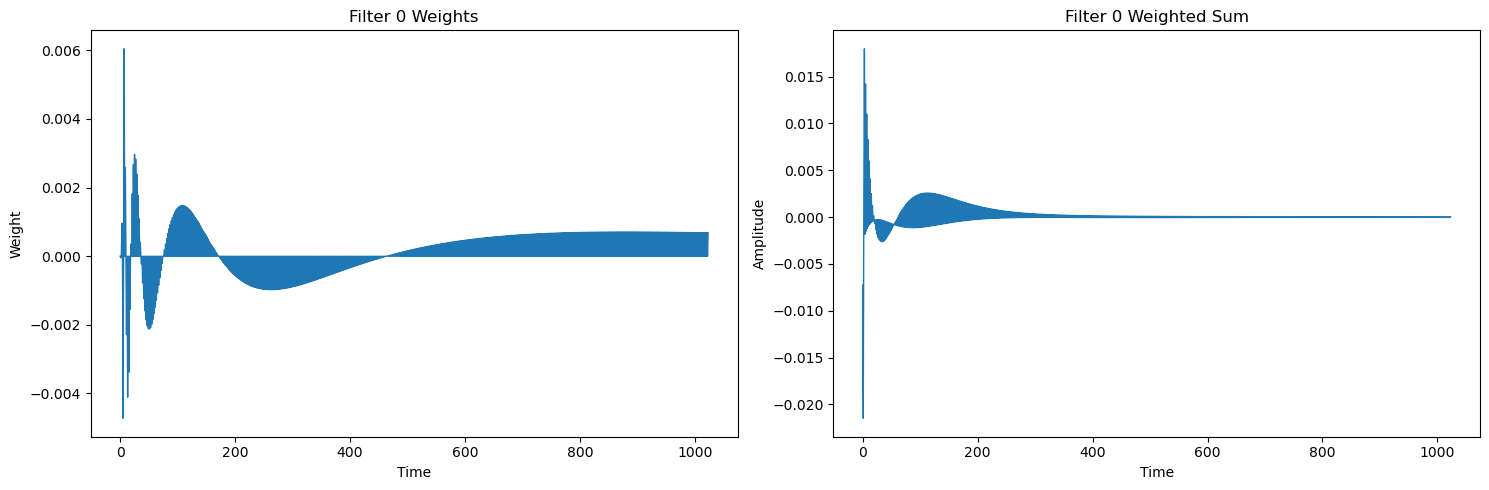

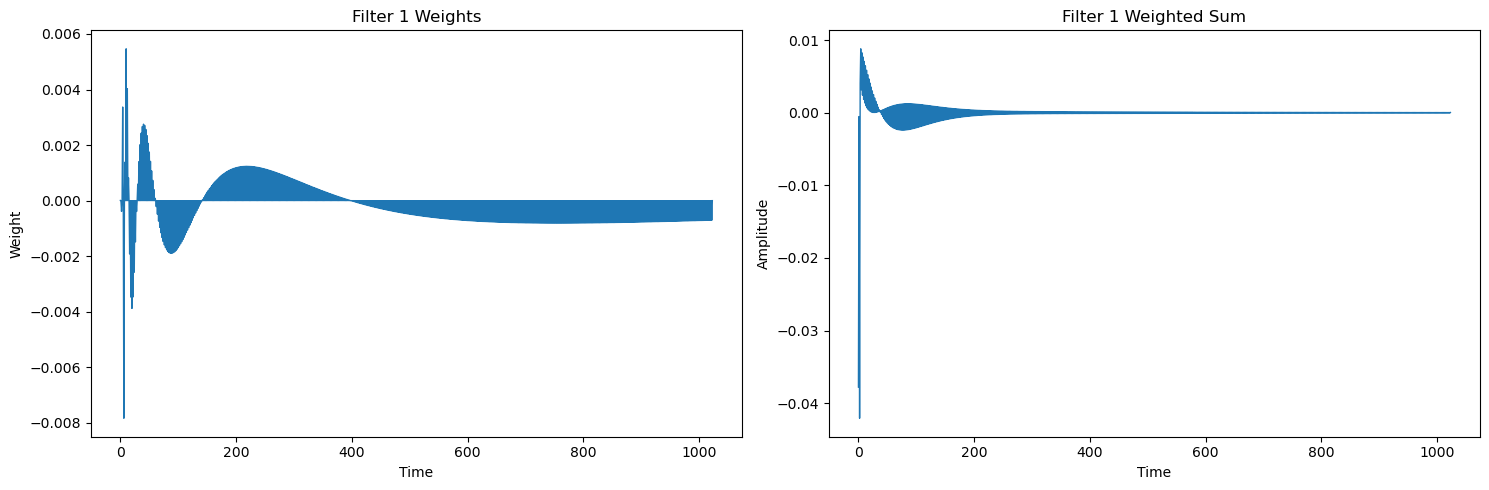

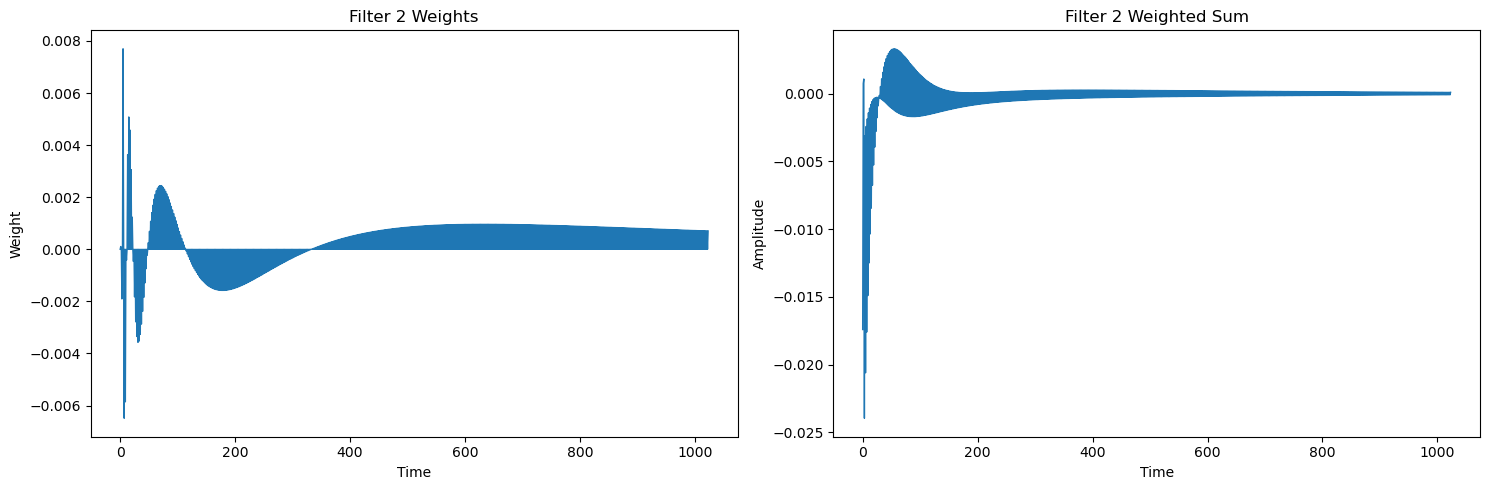

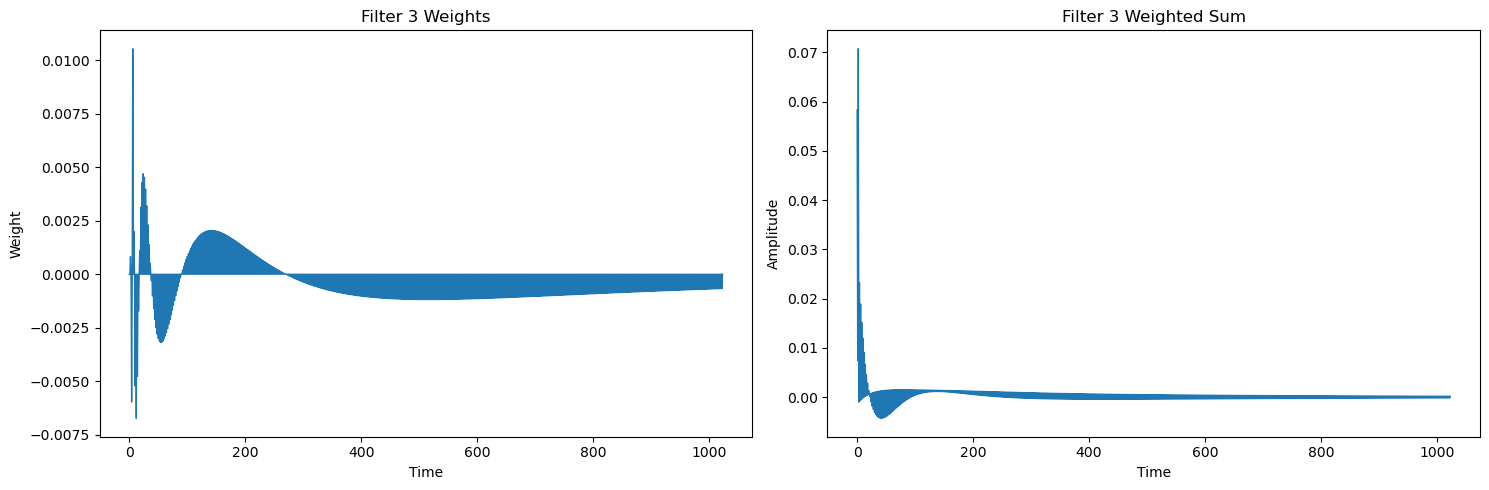

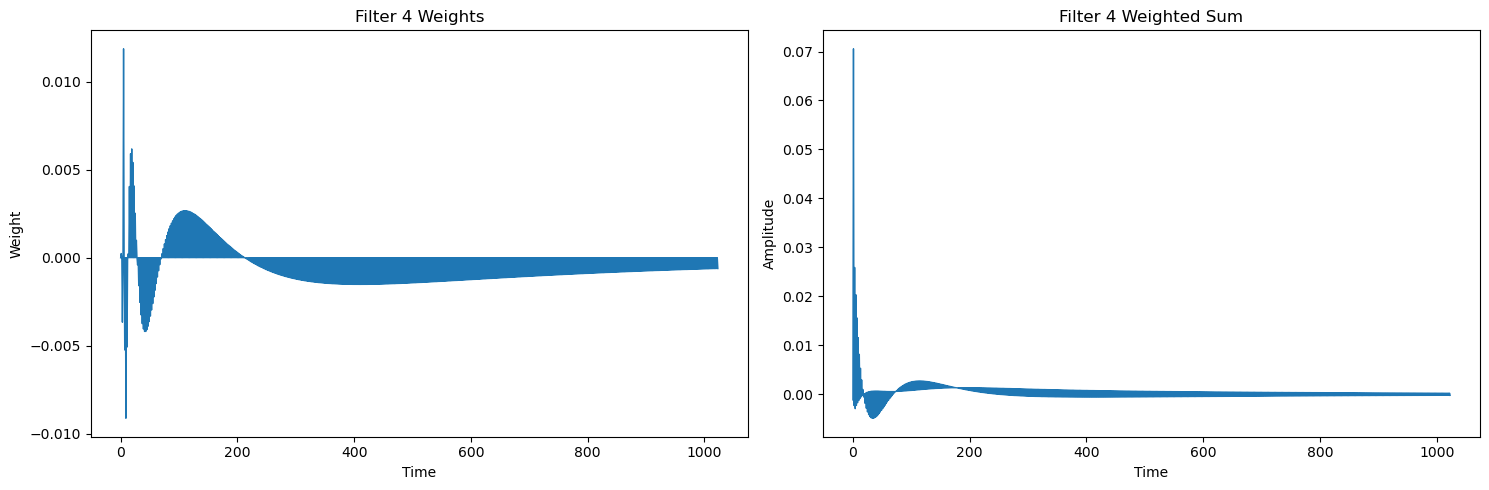

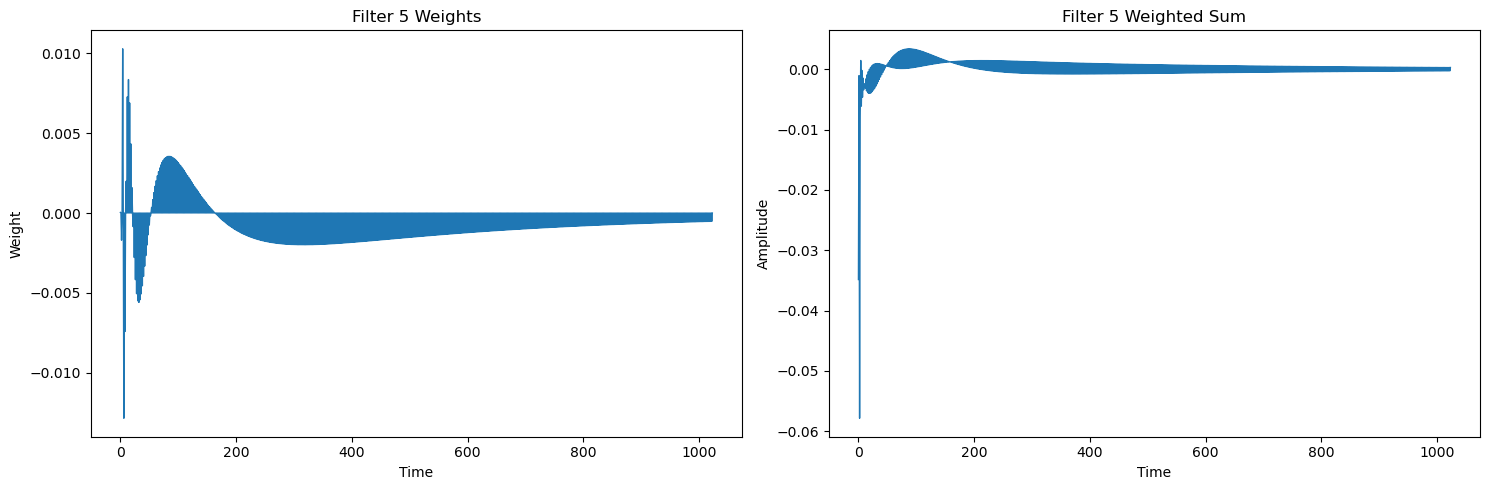

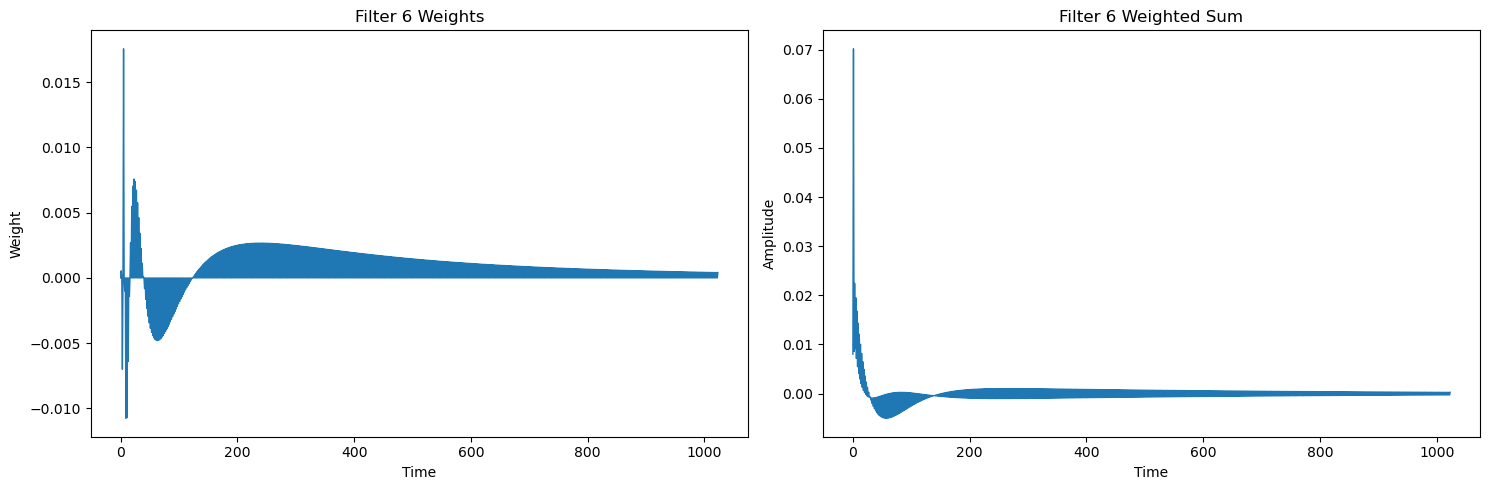

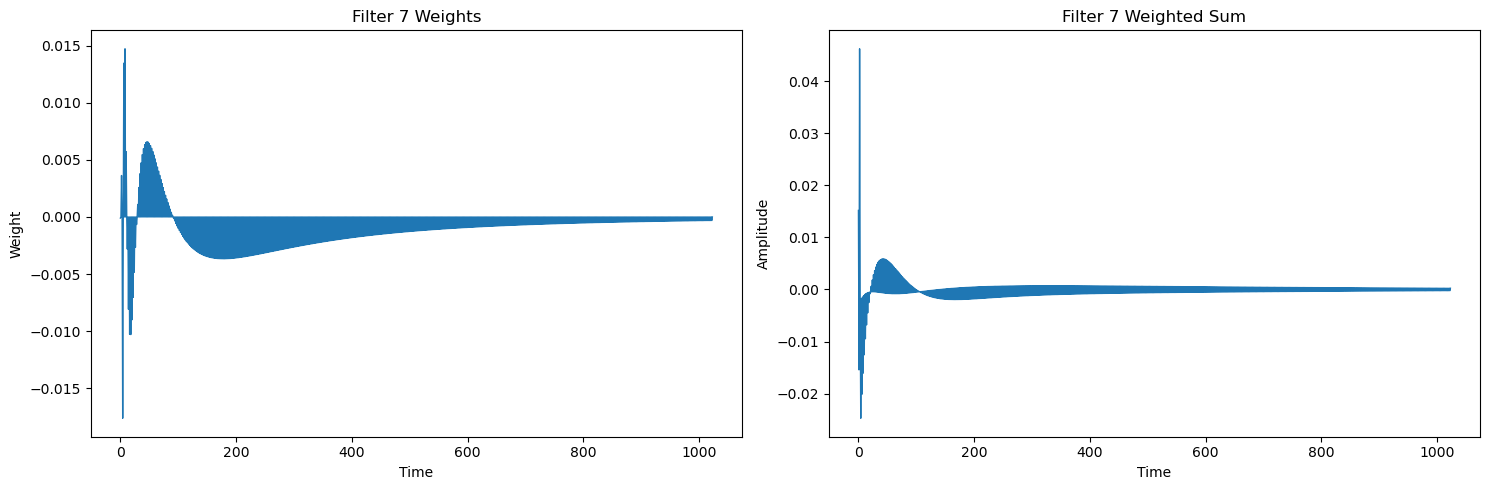

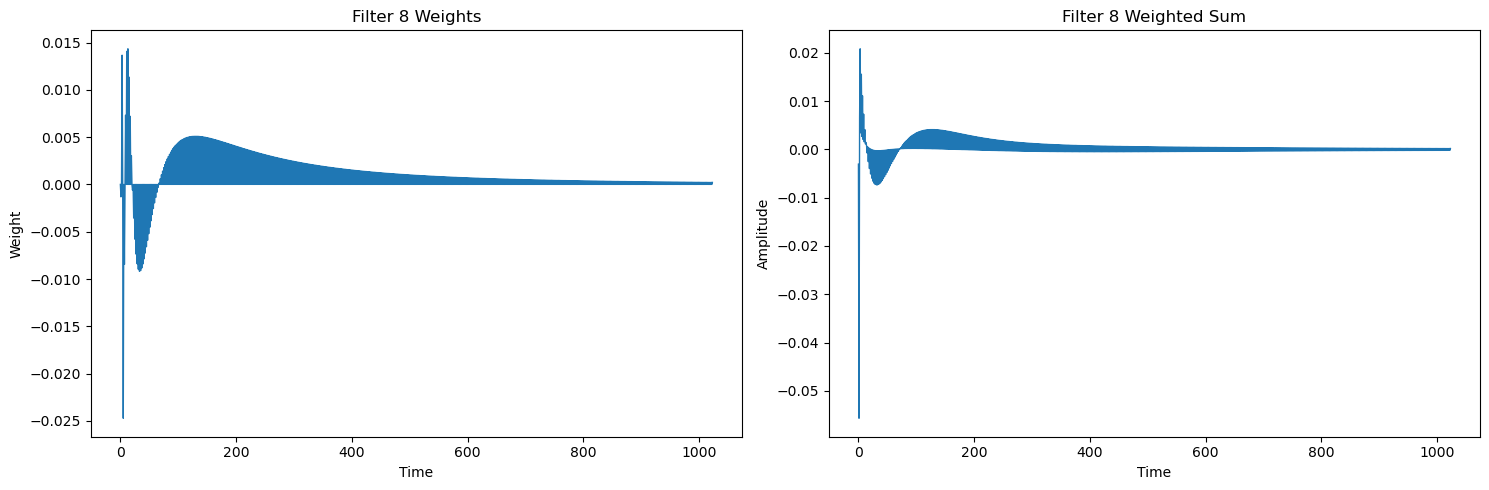

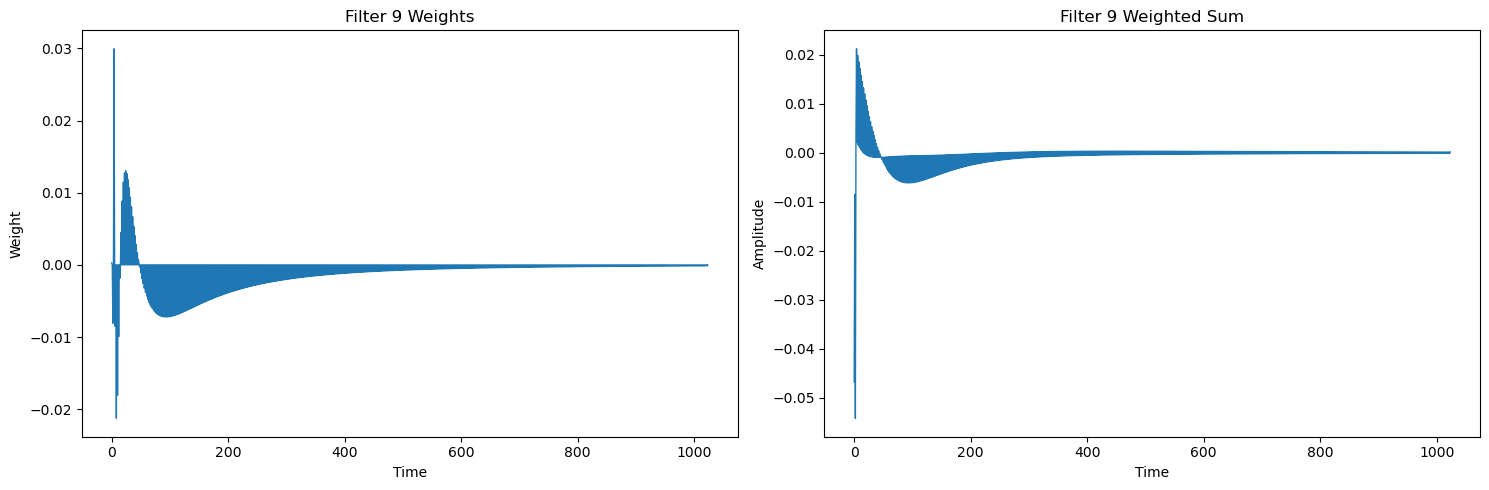

In [263]:

for i in range(10):
    plt.figure(figsize=(15, 5))
    
    # Plot the filter weights
    plt.subplot(1, 2, 1)
    plt.plot(phi[:,i].cpu(), '-', linewidth=1)
    plt.title(f'Filter {i} Weights')
    plt.xlabel('Time')
    plt.ylabel('Weight')
    
    # Plot the weighted sum of LDS impulses
    plt.subplot(1, 2, 2)
    coefficients = combined_weights_pinv[i]
    weighted_sum = torch.matmul(coefficients, lds_tensor)
    plt.plot(weighted_sum.detach().numpy(), '-', linewidth=1)
    plt.title(f'Filter {i} Weighted Sum')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    
    plt.tight_layout()
    plt.show()


In [264]:
impulse_list[0]

tensor([ 8.4799e-01,  2.0300e-01, -1.9169e-02,  ...,  2.9205e-22,
         2.7917e-22,  2.6685e-22])

In [265]:
alt_sign = lambda x: x * np.array([1, -1] * 512)

In [354]:
stu_model, _ = train_stu(lds)

Step 0: Loss = 10.882495880126953
Step 100: Loss = 4.143865953665227e-05
Step 200: Loss = 3.4449065424269065e-05
Step 300: Loss = 3.913104592356831e-05
Step 400: Loss = 3.29440736095421e-05


In [370]:
lds_impulse = torch.zeros(seq_len)
for i in range(stu_config["k_u"]):
    lds_impulse[i] = -1 * stu_model.M[0][0][i].detach().cpu().numpy() # but looks much better with -1.4 multiple
for i in range(seq_len):
    a_power = lds.A ** i
    lds_impulse[i] += torch.sum(lds.C[:, 0] * a_power * lds.B[0]).cpu()

In [371]:
impulse = gen_stu_impulse(stu_model)

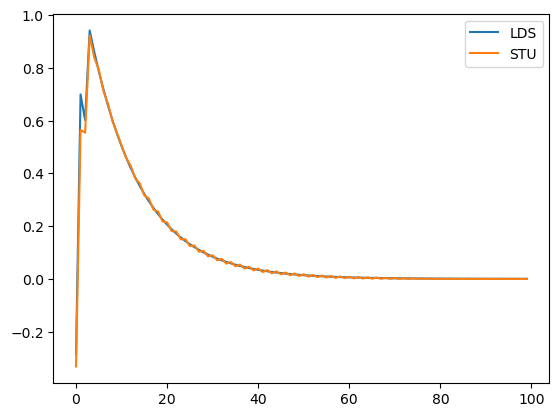

In [372]:
plt.plot(lds_impulse[:100], label = "LDS")
plt.plot(impulse[:100], label = "STU")
plt.legend()
plt.show()

#I NOTE THAT WE CAN HAND TWEAK THE IMPULSE FUNCTIONS BY THE DIFFERENCE FOR THE FIRST 3 TERMS TO MINIMIZE ERROR (just subtract diff and add it to autoreg params)